In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#pd.set_option('display.max_rows', None)

### Load Data

In [4]:
data = pd.read_csv('/home/jovyan/303project/techLayoffs.csv')
data.head(2)

,company,total_layoffs,impacted_workforce_percentage,reported_date,industry,headquarter_location,sources,status,additional_notes
0,C2FO,20,2,12/9/22,"Fintech, payments","Leawood, KS",Kansas City Business Journal,Private,NaN
1,VideoAmp,Unclear,2,9/19/22,Advertising platforms,Los Angeles,Company memo,Private,NaN


### Related Info of the Dataset

In [5]:
data.shape

(489, 9)

In [6]:
data.isnull().sum()

company                            0
total_layoffs                      0
impacted_workforce_percentage      0
reported_date                      0
industry                           0
headquarter_location               0
sources                            0
status                             0
additional_notes                 467
dtype: int64

In [7]:
data.duplicated().sum()

0

In [8]:
data.nunique()

company                          477
total_layoffs                    150
impacted_workforce_percentage     50
reported_date                    187
industry                         289
headquarter_location             134
sources                          221
status                             2
additional_notes                  22
dtype: int64

### Clean the Dataset

* #### 1. Drop 'additional_notes' column: not a lot of useful information are provided for further data anaylsis.

In [9]:
data = data.drop(columns = 'additional_notes')
data.head(2)

,company,total_layoffs,impacted_workforce_percentage,reported_date,industry,headquarter_location,sources,status
0,C2FO,20,2,12/9/22,"Fintech, payments","Leawood, KS",Kansas City Business Journal,Private
1,VideoAmp,Unclear,2,9/19/22,Advertising platforms,Los Angeles,Company memo,Private


* #### 2. Categorize 'industry': further group industry field so that there won't be overlapping indursties with different namings.

In [10]:
# Split the string in the 'industry' column by ','
dataS = data
dataS['industry'] = data['industry'].str.split(',')
dataS.head(2)

,company,total_layoffs,impacted_workforce_percentage,reported_date,industry,headquarter_location,sources,status
0,C2FO,20,2,12/9/22,"[Fintech, payments]","Leawood, KS",Kansas City Business Journal,Private
1,VideoAmp,Unclear,2,9/19/22,[Advertising platforms],Los Angeles,Company memo,Private


In [11]:
# Count frequency of unique 'industry' in the column
dataI = dataS
dataI = dataS.explode('industry', ignore_index=False)
dataI['industry'] = dataI['industry'].astype(str).str.lower().str.strip().str.replace('-','')
dataI['industry'].value_counts()

industry
fintech                52
ecommerce              47
health care            39
proptech               36
enterprise software    29
                       ..
legal tech              1
home decor              1
forestry                1
renewable energy        1
enterprise tech         1
Name: count, Length: 210, dtype: int64

##### Base on the list above, I then refine the industry names manually:
 - choose the most frequent word; if both words are frequently used, then whoever comes first before the comma will be adopted
 - lastly, I created a new column 'industryByStockMarket' to further group all industries by the industry indication of the stock market. 

* #### 3. Clean 'headquarter_location': contain only the city names (not the state names) in the 'headquarter_location' column.

In [37]:
# Get only the first element in the splitted list
dataH = data['headquarter_location'].str.split(',').str[0]
data['headquarter_location'] = dataH
data.head(2)

,company,total_layoffs,impacted_workforce_percentage,reported_date,industry,headquarter_location,sources,status
0,C2FO,20,2,12/9/22,"[Fintech, payments]",Leawood,Kansas City Business Journal,Private
1,VideoAmp,Unclear,2,9/19/22,[Advertising platforms],Los Angeles,Company memo,Private


Then, I used the Geocode add-ons to encode the latitude and longitude of each headquarter cities so that Tableau can show each position on the map.

### A Few Visualization 

#### Reload the cleaned dataset

In [38]:
dataM = pd.read_csv('/home/jovyan/303project/Manual_Tech_Layoff.csv')
#dataM = dataM.drop(columns = ['Latitude','Longitude'])
dataM.head(2)

,company,total_layoffs,impacted_workforce_percentage,reported_date,industry,industryByStockMarket,headquarter_location,Latitude,Longitude,sources,status
0,C2FO,20,2,12/9/22,FinTech,Financials,Leawood,38.966673,-94.616901,Kansas City Business Journal,Private
1,VideoAmp,Unclear,2,9/19/22,Marketing,Communication Services,Los Angeles,34.054908,-118.242643,Company memo,Private


In [39]:
#len(dataM['industry'].unique())

* #### Bar Chart - Top 10 Layoff Company

In [40]:
dataM['total_layoffs'] = dataM['total_layoffs'].apply(lambda x: 0 if not x.isnumeric() else int(x))

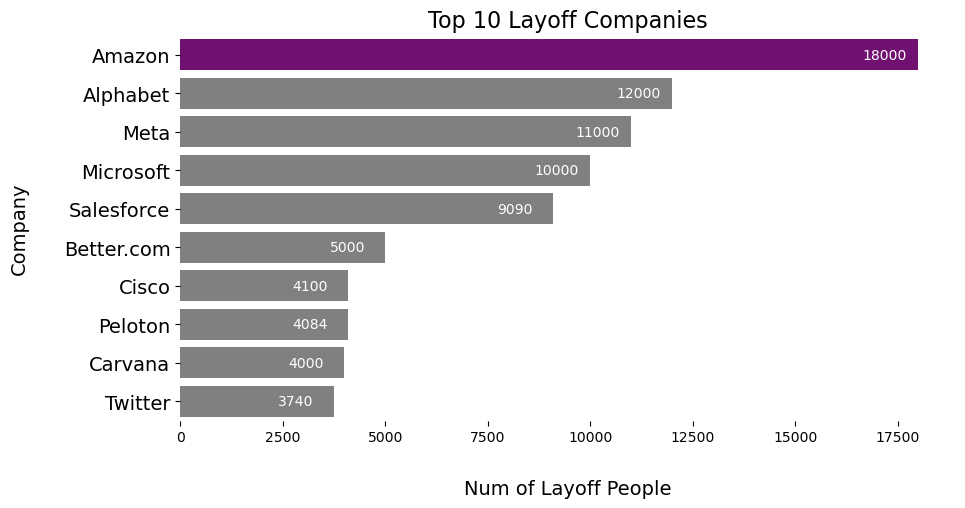

In [46]:
top_10 = dataM.sort_values('total_layoffs', ascending=False).head(10)
colors = ['grey'] * (len(top_10) - 1) + ['purple']

fig, ax = plt.subplots(figsize=(10, 5))
[ax.spines[i].set_visible(False) for i in ax.spines]
p = sns.barplot(x="total_layoffs", y="company", data=top_10, ax=ax, hue='total_layoffs', palette=colors, legend=False)
for container in p.containers:
    p.bar_label(container, padding=-40, color='white')
plt.yticks(fontsize=14)
plt.title("Top 10 Layoff Companies", fontsize=16)
plt.xlabel('Num of Layoff People', fontsize=14, labelpad=25)
plt.ylabel('Company', fontsize=14, labelpad=25)
plt.savefig('bar_company.png', bbox_inches='tight', facecolor='white')
plt.show()

* #### Bar Chart - Top 10 Layoff Industries

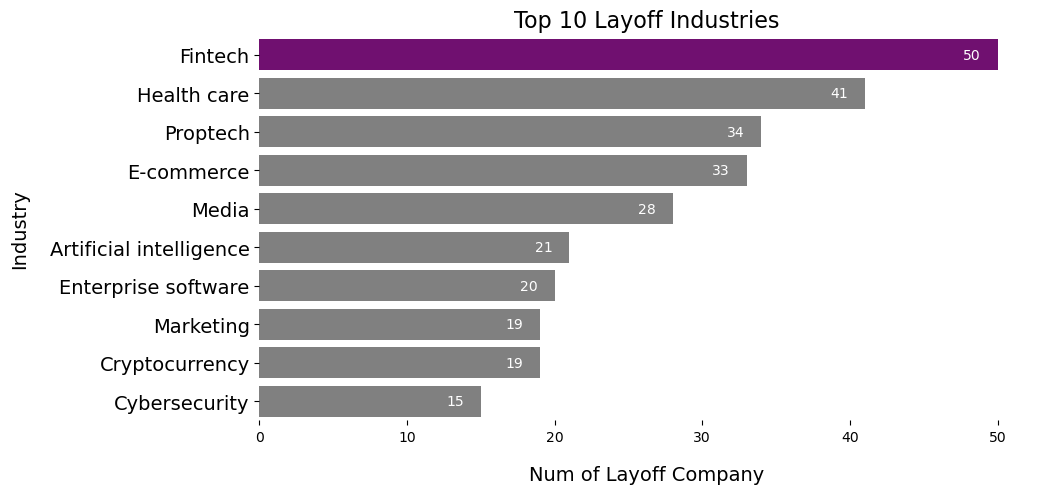

In [47]:
dataM['industry'] = [word.capitalize() for word in dataM['industry']]
top_10_industries = dataM['industry'].value_counts().head(10)
top_10_industries = dataM.groupby('industry').size().sort_values(ascending=False).head(10)
top_10_industries = top_10_industries.to_frame().reset_index()
colors = ['purple'] + ['grey'] * (len(top_10_industries) - 1)

fig, ax = plt.subplots(figsize=(10, 5))
[ax.spines[i].set_visible(False) for i in ax.spines]
p=sns.barplot(y='industry', x=0, data=top_10_industries, ax=ax, hue='industry', palette=colors, legend = False)
for container in p.containers:
    p.bar_label(container, padding=-25, color='white')
plt.yticks(fontsize=14)
plt.title("Top 10 Layoff Industries", fontsize = 16)
plt.xlabel('Num of Layoff Company', fontsize = 14, labelpad = 15)
plt.ylabel('Industry', fontsize = 14, labelpad = 15)
plt.savefig('bar_industry.png', bbox_inches = 'tight', facecolor = 'white') 
plt.show()

* #### Bar Chart - Top 10 Layoff Headquarter Locations

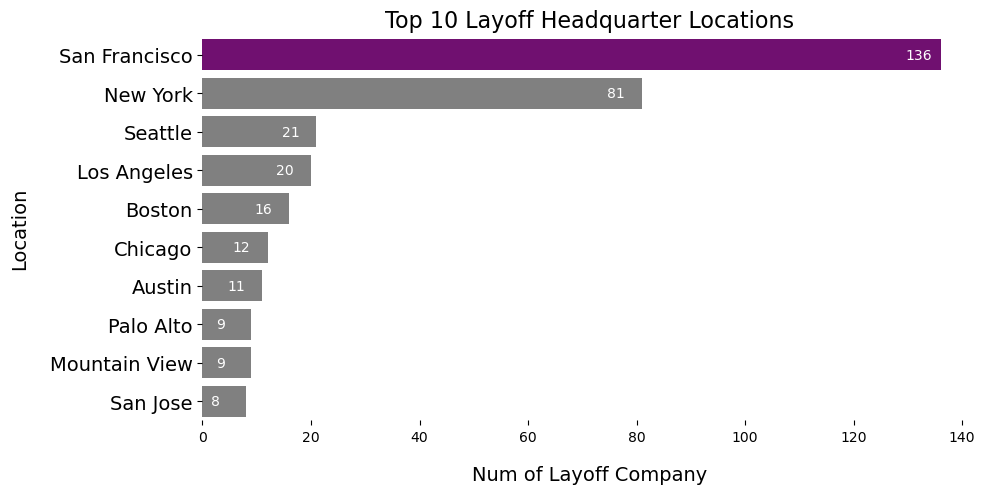

In [48]:
top_10_location = dataM['headquarter_location'].value_counts().head(10)
top_10_location = dataM.groupby('headquarter_location').size().sort_values(ascending=False).head(10)
top_10_location = top_10_location.to_frame().reset_index()
colors = ['purple'] + ['grey'] * (len(top_10_location) - 1)

fig, ax = plt.subplots(figsize=(10, 5))
[ax.spines[i].set_visible(False) for i in ax.spines]
p=sns.barplot(y='headquarter_location', x=0, data=top_10_location, ax=ax, hue='headquarter_location', palette=colors, legend = False)
for container in p.containers:
    p.bar_label(container,padding=-25, color='white')
plt.yticks(fontsize=14)
plt.title("Top 10 Layoff Headquarter Locations", fontsize = 16)
plt.xlabel('Num of Layoff Company', fontsize = 14, labelpad = 15)
plt.ylabel('Location', fontsize = 14, labelpad = 15)
plt.savefig('bar_location.png', bbox_inches = 'tight', facecolor = 'white') 
plt.show()

* #### Bar Chart - Private vs. Public Layoffs

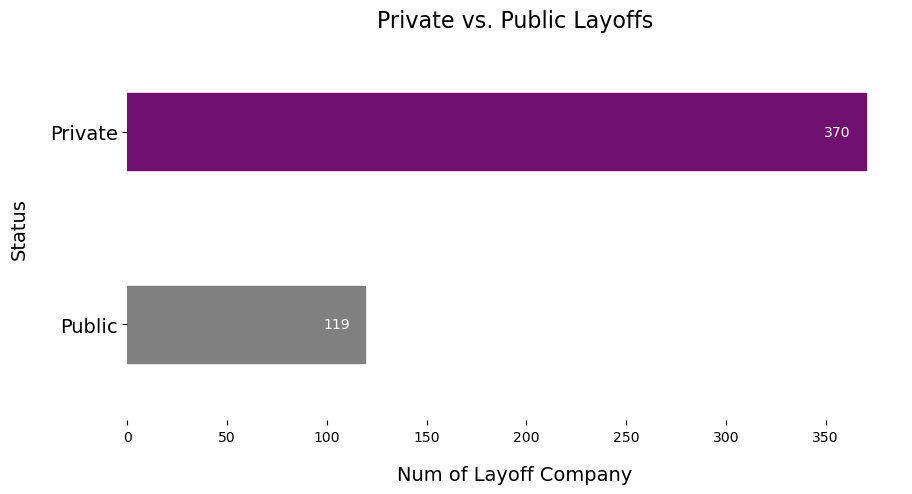

In [49]:
unique_statuses = dataM['status'].unique()
colors = ['purple' if status == unique_statuses[0] else 'grey' for status in unique_statuses]

fig, ax = plt.subplots(figsize=(10, 5))
[ax.spines[i].set_visible(False) for i in ax.spines]
p = sns.countplot(y="status", data=dataM, ax=ax, orient="h", hue = 'status', palette=colors, width=0.4)
for container in p.containers:
    for patch in container:
        current_color = patch.get_facecolor()
        patch.set_edgecolor(current_color)
    p.bar_label(container, padding=-30, color='white')
plt.yticks(fontsize=14)
plt.title("Private vs. Public Layoffs", fontsize=16)
plt.xlabel('Num of Layoff Company', fontsize=14, labelpad=15)
plt.ylabel('Status', fontsize=14, labelpad=15)
plt.savefig('bar_status.png', bbox_inches='tight', facecolor='white')
plt.show()